## Econ_570_HW2      Guoheng Wu

### Function

In [1]:
def fn_generate_cov(dim,corr):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

# Generate all Covariates X variable
def fn_generate_multnorm(nobs, corr, nvar):
    std = (np.abs(np.random.normal(loc = 1, scale = 0.5,size = (nvar,1))))**(1/2)
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(0,std[i],nobs),(nobs,1)))
    
    normvars = np.concatenate(acc,axis=1)
    cov = fn_generate_cov(nvar,corr)
    c = np.linalg.cholesky(cov)
    X = np.transpose(np.dot(c,np.transpose(normvars)))
    return X

# Generate Confounder variable C
def fn_randomize_conf(nobs):
    conf = np.reshape(np.random.normal(4,2,nobs),(nobs,1))
    return conf

# Generate Treatment variable T
def fn_randomize_treatment(nobs,conf,C):
    T = []
    if conf==False:
        for i in range(nobs):
            t = np.random.choice(np.arange(0, 2), p=[0.5, 0.5])
            T.append(t)
    if conf==True:
        for i in range(nobs):
            t = np.random.choice(np.arange(0, 2), p=[0.5-0.025*float(C[i]), 0.5+0.025*float(C[i])])
            T.append(t)
    return np.reshape(T,(nobs,1))

# Generate Variable between the path from the treatment to the outcome S
def fn_randomize_s(nobs,T):
    S = []
    for i in range(nobs):
        s = np.random.choice(np.arange(0, 2), p=[0.5-0.1*float(T[i]), 0.5+0.1*float(T[i])])
        S.append(s)
    return np.reshape(S,(nobs,1))

# Generate Data
def fn_generate_data(tau,N,p,corr,conf,sv):

    if conf==False:
        conf_mult = 0 
    if conf==True:
        conf_mult = 1
    if sv==False:
        s_mult = 0
    if sv==True:
        s_mult = 1
    
    X = fn_generate_multnorm(N,corr,p)
    C = fn_randomize_conf(N)
    T = fn_randomize_treatment(N,conf,C)
    S = fn_randomize_s(N,T)
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    Yab = tau*T+X@beta0+conf_mult*0.6*C+s_mult*1*S+err
        
    if conf==False and sv==False:
        return (Yab,T,X)   
    if conf==True and sv==False:
        return (Yab,T,X,C)
    if conf==False and sv==True:
        return (Yab,T,X,S)    
    if conf==True and sv==True:
        return (Yab,T,X,C,S) 

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

# Return estimate tauhats and sehats
def fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s):

    tauhats = []
    sehats = []
    for r in tqdm(Nrange):
        if conf==False and sv==False:
            if control_flagX==False:
                Yexp,T,X = fn_generate_data(tau,N,p,corr,conf,sv)
                Yt = Yexp[np.where(T==1)[0],:]
                Yc = Yexp[np.where(T==0)[0],:]
                tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
            if control_flagX==True:
                Yexp,T,X = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
        if conf==True and sv==False:
            if control_conf==False:
                Yexp,T,X,C = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
            if control_conf==True:
                Yexp,T,X,C = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X,C],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
        if conf==False and sv==True:
            if control_s==False:
                Yexp,T,X,S = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
            if control_s==True:
                Yexp,T,X,S = fn_generate_data(tau,N,p,corr,conf,sv)
                covars = np.concatenate([T,X,S],axis = 1)
                mod = sm.OLS(Yexp,covars)
                res = mod.fit()
                tauhat = res.params[0]
                se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]          
    return (tauhats,sehats)

# Return bias,rmse,size of treatment effect estimate
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat
    size = np.mean(1*(np.abs(tval)>cval))
    return (bias,rmse,size)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import graphviz as gr
import random
from tqdm import tqdm
import statsmodels.api as sm

# 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.

#### $y_i = \tau*T_i+\beta'*X_i+e_i$

##### 1.1 Simulate a DGP

In [3]:
tau = 3
corr = .5
conf = False
sv = False
p = 3
N = 1000
(Yab,T,X) = fn_generate_data(tau,N,p,corr,conf,sv)
data1 = np.concatenate((Yab,T,X),axis=1)
Data1 = pd.DataFrame(np.array(data1), columns=['Y','T','x1','x2','x3',])
Data1

,Y,T,x1,x2,x3
0,4.542495,0.0,-0.303630,-0.243272,-0.928186
1,-1.483708,1.0,-0.146598,0.186781,0.423251
2,4.064908,1.0,-1.620561,-0.260921,-0.417264
3,3.339060,1.0,-0.858866,-0.115051,-0.085675
4,-3.198980,0.0,0.568730,-0.167513,0.326894
...,...,...,...,...,...
995,4.552629,1.0,0.450306,0.488858,0.205315
996,4.312938,0.0,0.675622,1.263295,0.320321
997,3.786552,1.0,-0.297619,0.018928,0.292351
998,7.459664,1.0,-1.741210,-0.836639,-1.298153


##### 1.2 Illustrate the DGP with a DAG

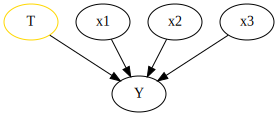

In [4]:
g = gr.Digraph()
g.edge("T", "Y"),g.node("T", color="gold")
g.edge("x1", "Y"),g.edge("x2", "Y"),g.edge("x3", "Y")
g

##### 1.3 Using a Monte Carlo experiment

a. Do not control for any covariates

In [5]:
control_conf=False
control_flagX=False
control_s=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.16it/s]

N=100: bias=-0.1544156951162044, RMSE=3.0409286600886754, size=0.0505
N=1000: bias=0.017661301791664145, RMSE=0.9607420689300841, size=0.051


b. Control for all the covariates that affect the outcome

In [6]:
control_conf=False
control_flagX=True
control_sv=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.80it/s]

N=100: bias=-0.0003034654481782564, RMSE=0.14483063248298667, size=0.054
N=1000: bias=0.0001923707206734677, RMSE=0.04510518510170598, size=0.053


##### 1.4 Give an example of a real-life situation that might be consistent with the DGP.

### If we want to test the effect of education(Uneducated or educated) on income, Age, IQ and family background are observed covariates that will also affect income, so they should be control.

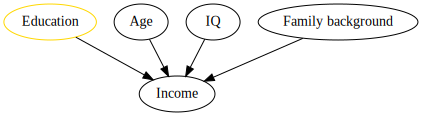

In [7]:
g = gr.Digraph()
g.edge("Education", "Income"),g.node("Education", color="gold")
g.edge("Age", "Income"),g.edge("IQ", "Income"),g.edge("Family background", "Income")
g

# 2. Simulate a DGP with a confounder


#### $y_i = \tau*T_i+\beta'*X_i+\alpha'*C_i+e_i$

##### 2.1 Simulate a DGP

In [8]:
tau = 4
corr = .4
conf = True
flagX = True
sv = False
p = 3
N = 1000
(Yab,T,X,C) = fn_generate_data(tau,N,p,corr,conf,sv)
data2 = np.concatenate((Yab,T,X,C),axis=1)
Data2 = pd.DataFrame(np.array(data2), columns=['Y','T','x1','x2','x3','C'])
Data2

,Y,T,x1,x2,x3,C
0,9.508728,1.0,-0.332990,0.694532,0.115403,3.135209
1,12.168810,1.0,-0.269907,-0.214294,0.718163,1.083125
2,7.775126,0.0,-0.319314,0.465294,0.198685,6.853592
3,-13.220471,1.0,-1.428525,-1.654021,-0.676871,5.838955
4,-5.296059,1.0,-0.492015,-0.478885,-0.597328,2.914141
...,...,...,...,...,...,...
995,0.889742,0.0,-0.120277,0.088200,-0.174567,4.232798
996,0.585875,0.0,-1.038221,-0.415435,0.479984,0.429668
997,3.389831,1.0,-0.650333,0.302697,-0.054984,1.738015
998,24.165534,1.0,1.496860,0.479524,0.801072,2.482929


##### 2.2 Illustrate the DGP with a DAG

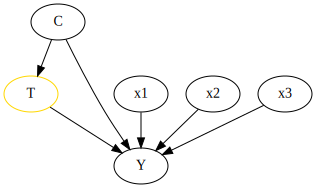

In [9]:
g = gr.Digraph()
g.edge("T", "Y"),g.node("T", color="gold")
g.edge("C", "T"),g.edge("C", "Y")
g.edge("x1", "Y"),g.edge("x2", "Y"),g.edge("x3", "Y")
g

##### 2.3 Using a Monte Carlo experiment

a. Fail to control for the confounder

In [10]:
control_conf=False
control_flagX=True
control_s=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.20it/s]

N=100: bias=2.5066269961960934, RMSE=2.5144783571941565, size=1.0
N=1000: bias=2.499183209022602, RMSE=2.5000034402960165, size=1.0


b. Do control for the confounder

In [11]:
control_conf=True
control_flagX=True
control_s=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = tau*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.38it/s]

N=100: bias=0.006429689158677604, RMSE=0.1928300474540253, size=0.0545
N=1000: bias=-0.0014419408603055506, RMSE=0.05973898471661796, size=0.0475


##### 2.4 Give an example of a real-life situation that might be consistent with the DGP


### If we want to assess the effects of smoking on people's health. The degree of people concern about their health is the confounder, since it partly determines whether people smoke or not, and it also affect the health. Therefore, it is essential to control for it.

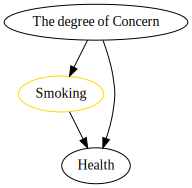

In [12]:
g = gr.Digraph()
g.edge("Smoking", "Health"),g.node("Smoking", color="gold")
g.edge("The degree of Concern", "Smoking"),g.edge("The degree of Concern", "Health")
g

# 3. Simulate a DGP with selection bias into the treatment

#### $y_i = \tau*T_i+\beta'*X_i+\alpha'*S_i+e_i$

##### 3.1 Simulate a DGP

In [13]:
tau = 5
corr = .5
conf = False
flagX = True
sv = True
p = 3
N = 1000
(Yab,T,X,S) = fn_generate_data(tau,N,p,corr,conf,sv)
data3 = np.concatenate((Yab,T,X,S),axis=1)
Data3 = pd.DataFrame(np.array(data3), columns=['Y','T','x1','x2','x3','S'])
Data3

,Y,T,x1,x2,x3,S
0,-46.743692,1.0,-0.696569,-1.257665,-2.576155,1.0
1,14.344194,0.0,0.379108,0.814514,0.200935,1.0
2,-38.917504,0.0,-2.270885,-1.097012,-0.742237,0.0
3,5.335245,0.0,-0.994142,-0.622819,1.244126,0.0
4,-17.662137,0.0,-1.299165,-0.321498,-0.265444,0.0
...,...,...,...,...,...,...
995,-3.515280,1.0,0.280009,-0.853783,-0.459286,1.0
996,-11.330205,0.0,-2.084976,-0.238290,0.686844,0.0
997,29.755596,0.0,1.294296,1.812507,0.276850,0.0
998,36.302409,1.0,0.142494,0.104393,2.008951,1.0


##### 3.2 Illustrate the DGP with a DAG

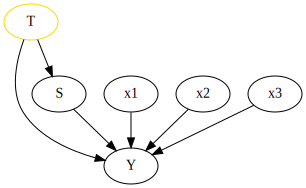

In [14]:
g = gr.Digraph()
g.edge("T", "Y"),g.node("T", color="gold")
g.edge("T", "S"),g.edge("S", "Y")
g.edge("x1", "Y"),g.edge("x2", "Y"),g.edge("x3", "Y")
g

##### 3.3 Using a Monte Carlo experiment

a. Control for the variable in between the path from cause to effect

In [15]:
control_conf=False
control_flagX=True
control_s=True
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = (tau+0.6)*np.ones([len(Nrange),1]) # 0.6 is the probability of S get 1
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [01:21<00:00, 24.45it/s]

N=100: bias=-0.5961914014685952, RMSE=0.6221914948840234, size=0.9215
N=1000: bias=-0.5987157476334474, RMSE=0.6012477713298326, size=1.0


b. Do not control for the variable in between the path from cause to effect

In [16]:
control_conf=False
control_flagX=True
control_s=False
estDict = {}
Nrange = range(2000)
for N in [100,1000]:
    tauhats,sehats = fn_get_estimate(tau,Nrange,p,corr,conf,sv,control_conf,control_flagX,control_s)
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

tau0 = (tau+0.6)*np.ones([len(Nrange),1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.77it/s]

N=100: bias=0.0020460935694010126, RMSE=0.1632316773836265, size=0.065
N=1000: bias=-0.000955341174656847, RMSE=0.049814004199282905, size=0.053


##### 3.4 Give an example of a real-life situation that might be consistent with the DGP

### We want to evaluate the effect of credit incentives to people's consumption levels. Credit incentives affect whether people take out loans and thus change consumption levels. We should not control the variables of whether people take out loans or not, since it's in the path from treatment to outcome.

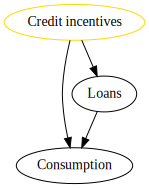

In [17]:
g = gr.Digraph()
g.edge("Credit incentives", "Consumption"),g.node("Credit incentives", color="gold")
g.edge("Credit incentives", "Loans"),g.edge("Loans", "Consumption")
g